## Pre-processing utilities functions

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import zipfile
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from dataset import CheXpertDataset


# Global helper functions
def get_class_names():
    return [
        'Pleural Effusion'
    ]

def get_policies():
    return [
        'ones',
        'zeroes',
        'mixed'
    ]

# Global preprocessing functions

def prepare_dataset(dataframe, policy, class_names):
    """
    Prepare the dataset by filtering, shuffling, and filling missing values.

    Parameters:
    - dataframe: The input DataFrame containing the dataset.
    - policy: The policy to handle uncertain labels (-1). Options are "ones", "zeroes", "mixed".
    - class_names: List of class names for the medical conditions.

    Returns:
    - x_path: Numpy array of image paths.
    - y: Numpy array of labels corresponding to the class names.
    """

    
    # Count the occurrences of each unique value in the "Pleural Effusion" column
    pleural_effusion_counts = dataframe['Pleural Effusion'].value_counts()

    # Print the counts for each class
    print(f"in dataframe Count for each class:\n{pleural_effusion_counts}")


    # Filter the dataset to include only frontal images
    dataset_df = dataframe[dataframe['Frontal/Lateral'] == 'Frontal']

    dataset_df = dataset_df.dropna(subset=['Pleural Effusion'])

     # Count the occurrences of each unique value in the "Pleural Effusion" column
    pleural_effusion_counts = dataset_df['Pleural Effusion'].value_counts()

    # Print the counts for each class
    print(f"in dataset_df (only Frontal) Count for each class:\n{pleural_effusion_counts}")
    
    # # Shuffle the dataset
    # df = dataset_df.sample(frac=1., random_state=1)
    
    # Fill missing values with zeros
    # df.fillna(0, inplace=True)
    
    # Extract image paths and labels
    x_path = dataset_df["Path"].to_numpy()
    y_df = dataset_df[class_names]

    # Count the occurrences of each unique value in the "Pleural Effusion" column
    pleural_effusion_counts = y_df.value_counts()
    print(f"in y_df Count for each class:\n{pleural_effusion_counts}")
    
    # Define classes to be treated as ones in the "mixed" policy
    class_ones = ['Atelectasis', 'Cardiomegaly']
    
    # Initialize the labels array
    y = np.empty(y_df.shape, dtype=int)
    
    # Define a dictionary to map policies to their corresponding actions
    policy_actions = {
        "ones": lambda cls: 1,
        "zeroes": lambda cls: 0,
        "mixed": lambda cls: 1 if cls in class_ones else 0
    }
    
    # Iterate over each row in the labels DataFrame
    for i, (index, row) in enumerate(y_df.iterrows()):
        labels = []
        # Iterate over each class name
        for cls in class_names:
            curr_val = row[cls]
            if curr_val:
                curr_val = float(curr_val)
                if curr_val == 1:
                    feat_val = 1
                elif curr_val == -1:
                    feat_val = policy_actions.get(policy, lambda cls: 0)(cls)
                else:
                    feat_val = 0
            else:
                feat_val = 0
            
            labels.append(feat_val)
        
        # Assign the labels to the corresponding row in the labels array
        y[i] = labels

    # Assuming y is a numpy array
    # Flatten the y array
    y_flattened = y.flatten()

    # Convert the flattened array to a pandas Series
    y_series = pd.Series(y_flattened)

    # Get the value counts of each unique value
    pleural_effusion_counts = y_series.value_counts()
    print(f"in y (labels) Count for each class:\n{pleural_effusion_counts}")
    
    return x_path, y

def split_train_val(train_df, policy, class_names, test_size=0.2, random_state=42):
    """
    Split the training data into training and validation sets.

    Parameters:
    - train_df: DataFrame containing the training data.
    - policy: The policy to handle uncertain labels (-1). Options are "ones", "zeroes", "mixed".
    - class_names: List of class names for the medical conditions.
    - test_size: Proportion of the training data to include in the validation set.
    - random_state: Random seed for reproducibility.

    Returns:
    - train_df: DataFrame containing the training data.
    - val_df: DataFrame containing the validation data.
    """
    # Prepare the training dataset
    train_paths, train_labels = prepare_dataset(train_df, policy, class_names)
    
    # Split the training dataset into training and validation sets
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        train_paths, train_labels, test_size=test_size, random_state=random_state
    )
    
    # Create DataFrames for the training and validation sets
    train_df = pd.DataFrame({'path': train_paths})
    train_labels_df = pd.DataFrame(train_labels, columns=class_names)
    train_df = pd.concat([train_df, train_labels_df], axis=1)
    
    val_df = pd.DataFrame({'path': val_paths})
    val_labels_df = pd.DataFrame(val_labels, columns=class_names)
    val_df = pd.concat([val_df, val_labels_df], axis=1)
    
    return train_df, val_df

def prepare_test_dataset(valid_df, policy, class_names):
    """
    Prepare the test dataset (original validation set).

    Parameters:
    - valid_df: DataFrame containing the original validation data.
    - policy: The policy to handle uncertain labels (-1). Options are "ones", "zeroes", "mixed".
    - class_names: List of class names for the medical conditions.

    Returns:
    - test_df: DataFrame containing the test data.
    """
    # Prepare the test dataset
    test_paths, test_labels = prepare_dataset(valid_df, policy, class_names)
    
    # Create DataFrame for the test set
    test_df = pd.DataFrame({'path': test_paths})
    test_labels_df = pd.DataFrame(test_labels, columns=class_names)
    test_df = pd.concat([test_df, test_labels_df], axis=1)
    
    return test_df


def get_datasets(zip_path='chexpert.zip'):
    """
    Get the training, validation, and test datasets.
    """
    # Read the training and validation data from the zip file
    original_train_df, test_df = read_zip(zip_path=zip_path)

    # Count the occurrences of each unique value in the "Pleural Effusion" column
    pleural_effusion_counts = original_train_df['Pleural Effusion'].value_counts()

    # Print the counts for each class
    print(f"in original_train_df Count for each class:\n{pleural_effusion_counts}")

    policies = get_policies()
    class_names = get_class_names()

    # Select the policy to handle uncertain labels (-1)
    # We started with mixed policy which changed -1  to 0 but got bad results so switched to ones policy
    # which changes -1 to 1
    selected_policy = policies[0]

    # Split the original training data into separate training 
    # and validation sets while preserving the original 
    # validation test set as the final test set.
    train_df, validation_df = split_train_val(original_train_df, selected_policy, class_names)
    
    # Prepare the test dataset
    test_df = prepare_test_dataset(test_df, selected_policy, class_names)

    return train_df, validation_df, test_df


def read_zip(zip_path='chexpert.zip'):
    """
    Reading training and validation data from a zip file.
    """
    original_train_df, test_df = None, None

    # Read CSV files from the zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        with zip_ref.open('train.csv') as train_file:
            original_train_df = pd.read_csv(train_file)
        with zip_ref.open('valid.csv') as valid_file:
            test_df = pd.read_csv(valid_file)
    
    return original_train_df, test_df


def get_transform(augment=False):
    # Define the transformation pipeline for the images
    transform_list = [
        transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
        transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
        transforms.ToTensor(),          # Convert images to PyTorch tensors
        transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale images
    ]
    
    if augment:
        # Add data augmentation transformations to help with generalization
        # RandomHorizontalFlip: Randomly flip the image horizontally
        # RandomRotation: Randomly rotate the image by up to 10 degrees
        # RandomResizedCrop: Randomly crop the image to 224x224 pixels
        # ColorJitter: Randomly change the brightness, contrast, saturation, and hue of the image
        augmentations = [
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
        ]
        transform_list = augmentations + transform_list
    
    transform = transforms.Compose(transform_list)
    return transform

def get_transform_eval(augment=False):
    # Define the transformation pipeline for the images
    transform_list = [
        transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
        transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
        transforms.ToTensor(),          # Convert images to PyTorch tensors
        transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale images
    ]
    
    if augment:
        # Add data augmentation transformations to help with generalization
        # RandomHorizontalFlip: Randomly flip the image horizontally
        # RandomRotation: Randomly rotate the image by up to 10 degrees
        # RandomResizedCrop: Randomly crop the image to 224x224 pixels
        # ColorJitter: Randomly change the brightness, contrast, saturation, and hue of the image
        augmentations = [
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
        ]
        transform_list = augmentations + transform_list
    
    transform = transforms.Compose(transform_list)
    return transform


def transform_dataset(df, zip_path='chexpert.zip', batch_size=16, shuffle=True, augment=False):
    """
    Transform the dataset into DataLoader objects for given dataframe.

    Parameters:
    - df: DataFrame containing the dataset.
    - zip_path: Path to the zip file containing the images.
    - batch_size: Number of samples in each batch.
    - shuffle: Whether to shuffle the data.
    - augment: Whether to apply data augmentation.

    Returns:
    - dataset: CheXpertDataset object containing the dataset.
    - loader: DataLoader object containing the dataset.
    - images: Batch of images from the DataLoader.
    - labels: Batch of labels from the DataLoader.
    """
    # Define the class names for the medical conditions
    class_names = get_class_names()

    transformer = get_transform_eval()

    # Create the training dataset with the defined transformations 
    dataset = CheXpertDataset(dataframe=df, class_names=class_names, zip_path=zip_path, transform=transformer)

    # Create DataLoader for the training dataset
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    # Verify data loading by fetching a batch of images and labels from the training DataLoader
    images, labels = next(iter(loader))

    return dataset, loader, images, labels


## Dataset utils

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os


class CheXpertDataset(Dataset):
    def __init__(self, dataframe, class_names, zip_path, transform=None):
        self.dataframe = dataframe
        self.class_names = class_names
        self.transform = transform #use this later on to resize images and pre-process if we need it

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path']

        # if os.path.exists(f'/{zip_path}'):
        #   FOLDER = f'/{zip_path}/'
        # elif os.path.exists('/content/drive/MyDrive'):
        #   FOLDER = '/content/drive/MyDrive/CheXpert-v1.0-small/'
        # else:
        #   FOLDER = "" # Or handle the case where the directory doesn't exist
        FOLDER = ""
        img_path = FOLDER + img_path
        image = Image.open(img_path) # Convert to gray scalse   .convert('RGB')  #rgb format
        labels = self.dataframe.iloc[idx][self.class_names].values.astype('float32')  # astype float32 otherwise error
        labels = torch.tensor(labels, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, labels

## Training utilities functions

In [3]:
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

def upload_pretrained_densenet169(pretrained_model, add_layers=True, n_labels=1, freeze_layers=True, unfreeze_modules=['features.denseblock4']):
    """
    Modify a pre-trained model by adding custom layers and optionally freezing the original layers.

    Parameters:
    - pretrained_model: The pre-trained model to be modified.
    - add_layers: Boolean indicating whether to add custom layers.
    - n_labels: Number of output labels (classes).
    - freeze_layers: Boolean indicating whether to freeze the original layers.
    - unfreeze_layers: List of layer names or indices to unfreeze (e.g., 'features.denseblock4' or [6, 7] for certain blocks).

    Returns:
    - The modified model.
    """
    
    # Step 1: Freeze all layers
    if freeze_layers:
        for param in pretrained_model.parameters():
            param.requires_grad = False

    # Step 2: Unfreeze specific layers (if specified)
    if unfreeze_modules:
        for name, child in pretrained_model.named_modules():
            # Unfreeze layers based on the name of the block (e.g., 'features.denseblock4')
            if any(layer_name in name for layer_name in unfreeze_modules):
                # print('Works')
                for param in child.parameters():
                    param.requires_grad = True
    
    # Step 3: Modify the first convolutional layer to accept 1-channel input for DenseNet169
    pretrained_model.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    # Step 4: Add custom layers if specified
    if add_layers:
        in_features = pretrained_model.classifier.in_features
        pretrained_model.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, n_labels)
        )

    return pretrained_model


def evaluate_model(model, test_loader: DataLoader, criterion, device='cuda'):
    """
    Evaluate a trained PyTorch model on a test dataset.

    Parameters:
    - model: The trained PyTorch model.
    - test_loader: DataLoader for the test dataset.
    - criterion: The loss function used during training.
    - device: Device to evaluate the model on ('cpu' or 'cuda').

    Returns:
    - test_loss: Average loss on the test dataset.
    - test_accuracy: Overall accuracy on the test dataset.
    - all_predictions: List of predicted values for all samples.
    - all_labels: List of ground-truth labels for all samples.
    """
    # model.to(device)
    model.eval()  # Set the model to evaluation mode
    
    test_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating", unit="batch"):
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Convert outputs to binary predictions (multi-label classification)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            
            # Store predictions and labels
            all_predictions.append(predicted.cpu())
            all_labels.append(labels.cpu())

            correct += (predicted == labels).sum().item()
            total += labels.numel() # Total elements (samples × labels)
            
    test_loss /= len(test_loader)
    test_accuracy = correct / total

    # Convert pre`dictions and labels to tensors
    all_predictions = torch.cat(all_predictions, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return test_loss, test_accuracy, all_predictions, all_labels

##  Implementation of saliency map-based explanations

In [4]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# PyTorch libraries
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary

# Utilities
from IPython.display import display
from tqdm.notebook import tqdm

# Custom modules
# from preprocessing_utils import get_class_names, get_policies, get_datasets, transform_dataset, get_transform
# from training_utils import train_model, upload_pretrained_densenet169, predict_model, load_model, plot_roc_curve
# from dataset import CheXpertDataset

# LIME (Local Interpretable Model-agnostic Explanations)
import lime
import lime.lime_tabular
import lime.lime_image

### Global variables


In [5]:
transform = get_transform()

# Define the class names for the medical conditions
class_names = get_class_names()

# Define the policies for dataset preparation
policies = get_policies()

# Path to the zip file
zip_path = "./chexpert.zip"

# Path to the directory where the datasets will be extracted
data_dir = "./CheXpert-v1.0-small"

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the batch size
batch_size = 16

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

### Load the dataframe

In [6]:
# Load the datasets
train_df, validation_df, test_df = get_datasets(zip_path)



in original_train_df Count for each class:
Pleural Effusion
 1.0    86187
 0.0    35396
-1.0    11628
Name: count, dtype: int64
in dataframe Count for each class:
Pleural Effusion
 1.0    86187
 0.0    35396
-1.0    11628
Name: count, dtype: int64
in dataset_df (only Frontal) Count for each class:
Pleural Effusion
 1.0    76899
 0.0    25299
-1.0     9578
Name: count, dtype: int64
in y_df Count for each class:
Pleural Effusion
 1.0                76899
 0.0                25299
-1.0                 9578
Name: count, dtype: int64
in y (labels) Count for each class:
1    86477
0    25299
Name: count, dtype: int64
in dataframe Count for each class:
Pleural Effusion
0.0    167
1.0     67
Name: count, dtype: int64
in dataset_df (only Frontal) Count for each class:
Pleural Effusion
0.0    138
1.0     64
Name: count, dtype: int64
in y_df Count for each class:
Pleural Effusion
0.0                 138
1.0                  64
Name: count, dtype: int64
in y (labels) Count for each class:
0    138

In [7]:
validation_df

path  Pleural Effusion
0      CheXpert-v1.0-small/train/patient48924/study2/...                 1
1      CheXpert-v1.0-small/train/patient38687/study1/...                 1
2      CheXpert-v1.0-small/train/patient03187/study2/...                 1
3      CheXpert-v1.0-small/train/patient37033/study15...                 1
4      CheXpert-v1.0-small/train/patient25492/study1/...                 0
...                                                  ...               ...
22351  CheXpert-v1.0-small/train/patient10511/study41...                 1
22352  CheXpert-v1.0-small/train/patient23341/study1/...                 0
22353  CheXpert-v1.0-small/train/patient18983/study1/...                 0
22354  CheXpert-v1.0-small/train/patient21732/study1/...                 0
22355  CheXpert-v1.0-small/train/patient24663/study2/...                 1

[22356 rows x 2 columns]

### Extraction of ground truth samples (4 images)

In [8]:
ground_truth_df = pd.read_excel("/Users/nikitaksnv/Desktop/XAI_projectt/ExplainableAIRadiology/ground_truth_data/bbox320x320.xlsx")
ground_truth_df.head() 

Image   x_start  y_start   x_end   y_end  x_start.1  y_start .1  x_end .1  \
0   Test        48       160     144    288        NaN         NaN       NaN   
1  Rad_1       176       128     288    256        NaN         NaN       NaN   
2   Rad_2       32       128     144    256        NaN         NaN       NaN   
3  Rad_3        32       144     144    288      176.0       144.0     288.0   
4  Rad_5        32       160     144    240        NaN         NaN       NaN   

   y_end.1  
0      NaN  
1      NaN  
2      NaN  
3    272.0  
4      NaN

In [112]:
ground_truth_df

Image   x_start  y_start   x_end   y_end  x_start.1  y_start .1  x_end .1  \
0   Test        48       160     144    288        NaN         NaN       NaN   
1  Rad_1       176       128     288    256        NaN         NaN       NaN   
2   Rad_2       32       128     144    256        NaN         NaN       NaN   
3  Rad_3        32       144     144    288      176.0       144.0     288.0   
4  Rad_5        32       160     144    240        NaN         NaN       NaN   

   y_end.1  
0      NaN  
1      NaN  
2      NaN  
3    272.0  
4      NaN

# Extended to include the test image as well !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
images_paths = []
attributes_list = []

all_images_paths = []
all_attributes_list = []

for row, column in ground_truth_df.iterrows():
    if column['Image '] == "Test ":
        all_images_paths.append(f"ranking_annotations/test_image.png")
        all_attributes_list.append(column[['Image ', 'x_start', 'y_start ', 'x_end ', 'y_end']])
    else:
        path = f"ground_truth_images/{column['Image '].strip()}.png"
        all_images_paths.append(path)
        images_paths.append(path)
        attributes_list.append(column[['Image ', 'x_start', 'y_start ', 'x_end ', 'y_end']])
        all_attributes_list.append(column[['Image ', 'x_start', 'y_start ', 'x_end ', 'y_end']])

labels = np.array([1, 1, 1, 1])

In [115]:
ground_truth_images_df = pd.DataFrame({"path": images_paths, "label": labels})
ground_truth_images_df.head()

path  label
0  ground_truth_images/Rad_1.png      1
1  ground_truth_images/Rad_2.png      1
2  ground_truth_images/Rad_3.png      1
3  ground_truth_images/Rad_5.png      1

In [122]:
all_labels = np.array([1, 1, 1, 1, 1])
all_ground_truth_images = pd.DataFrame({"path": all_images_paths, "label": all_labels})


In [123]:
all_attributes_list[:2]

[Image       Test 
 x_start        48
 y_start       160
 x_end         144
 y_end         288
 Name: 0, dtype: object,
 Image       Rad_1 
 x_start        176
 y_start        128
 x_end          288
 y_end          256
 Name: 1, dtype: object]

### Upload the trained model

In [12]:
model_densenet = models.densenet201()
model = upload_pretrained_densenet169(model_densenet, add_layers=True, n_labels=len(class_names), freeze_layers=True)
state_dict = torch.load("finetuned_models/densenet201.pth", map_location=torch.device('cpu'))

In [13]:
model.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

In [14]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### Dataloader object

In [15]:
#### DataLoader object
test_dataset = CheXpertDataset(test_df, class_names, transform=transform, zip_path=None)
# Create DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

### Evaluation of the model

In [16]:
criterion = nn.BCEWithLogitsLoss()
test_loss, test_accuracy, predictions, true_labels = evaluate_model(model, test_loader, criterion)

Evaluating:   0%|          | 0/13 [00:00<?, ?batch/s]

Test Loss: 0.3680, Test Accuracy: 0.8267


In [17]:
# Ensure your model is in evaluation mode and on the proper device.
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## Gradcam based on paper: https://arxiv.org/abs/1610.02391
#### Library: https://github.com/jacobgil/pytorch-grad-cam

In [18]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import ScoreCAM

### Function to extract heat maps using GradCAM

In [20]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import ScoreCAM

def apply_gradcam(model, image_path, transform, target_layer=None):
    """
    Apply Grad-CAM to the specified image using the provided DenseNet121 model.
    
    Args:
        model: The trained DenseNet121 model.
        image_path: Path to the image for visualization.
        transform: Image transformation pipeline.
        target_layer: The target convolutional layer for Grad-CAM. If None, uses a default layer.
        target_category: (Optional) Target class index for which to compute Grad-CAM.
    
    Returns:
        Tuple of (resized original image, Grad-CAM heatmap, overlayed image).
    """
    # Ensure the model is in evaluation mode and gradients are enabled
    model.eval()
    for param in model.parameters():
        param.requires_grad = True

    # Load the image and get the original image (without resizing)
    img = Image.open(image_path).convert('RGB')
    original_img = np.array(img, dtype=np.float32) / 255.0  # Original resolution

    # Preprocess the image (this resizes the image to the size expected by the model)
    input_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    # If no target layer specified, choose the last conv layer in denseblock4.
    if target_layer is None:
        try:
            # Using the last convolution from denselayer16 in denseblock4       denseblock4{
            target_layer = [model.features.denseblock4.denselayer32.conv2] #  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                                                                                #} last layer  # otherwise this error https://github.com/jacobgil/pytorch-grad-cam/issues/393
        except AttributeError:
            # Fallback: use an alternative convolutional layer
            return "Not possible to extract the required convolutional layer due to missing attribute."

    # Create GradCAM object
    cam = GradCAM(model=model, target_layers=target_layer)

    targets = [ClassifierOutputTarget(0)]

    
    print(targets)

    # Generate Grad-CAM heatmap (this triggers the backward pass)
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    
    # print(grayscale_cam.min(), grayscale_cam.max())  # Before normalization
    # grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min() + 1e-8)
    # print(grayscale_cam.min(), grayscale_cam.max())  # After normalization
        
    # Resize the original image to match the Grad-CAM output dimensions if needed
    if original_img.shape[:2] != grayscale_cam.shape: #OTHERWISE  <<ValueError: operands could not be broadcast together with shapes (224,224,3) (320,357,3) THIS SH happens >> 
        original_img_resized = cv2.resize(original_img, (grayscale_cam.shape[1], grayscale_cam.shape[0])) 
    else:
        original_img_resized = original_img

    # Overlay the heatmap on the resized original image
    overlay = show_cam_on_image(original_img_resized, grayscale_cam, use_rgb=True) # https://github.com/jacobgil/pytorch-grad-cam/blob/master/pytorch_grad_cam/utils/image.py

    return original_img_resized, overlay

### Visualisation of gradcam with ground truth bounding boxes

In [21]:
def visualize_gradcam_with_bbox(model, ground_truth_images_df, ground_truth_df, transform, display_only_effusion=True):
    """
    Visualize GradCAM heatmaps with bounding boxes for medical images.
    
    Parameters:
    -----------
    model : torch.nn.Module
        The trained model (DenseNet169) for which to compute GradCAM
    ground_truth_images_df : pandas.DataFrame
        DataFrame containing image paths and labels
    ground_truth_df : pandas.DataFrame
        DataFrame containing bounding box coordinates
    transform : torchvision.transforms
        Image transformations to apply
    display_only_effusion : bool, default=True
        If True, only process images with effusion (label == 1)
    """
    import cv2
    import matplotlib.pyplot as plt
    from PIL import Image
    import pandas as pd
    
    for i in range(ground_truth_images_df.shape[0]):
        image_path = ground_truth_images_df.iloc[i]['path']
        actual_label = ground_truth_images_df.iloc[i]["label"]
        
        # Load BBOX coordinates
        x_start, y_start, x_end, y_end, x_start_, y_start_, x_end_, y_end_ = ground_truth_df.iloc[i][
            ['x_start', 'y_start ', 'x_end ', 'y_end', 'x_start.1', 'y_start .1', 'x_end .1', 'y_end.1']
        ]
        
        print(f"Actual label: {actual_label}")
        
        # Skip non-effusion images if display_only_effusion is True
        if display_only_effusion and actual_label != 1:
            continue
            
        # Apply GradCAM
        original_img, overlay = apply_gradcam(
            model=model,
            image_path=image_path,
            transform=transform,
        )
        
        # Scale BBOX coordinates to 224x224
        original_width, original_height = Image.open(image_path).size
        scale_x = 224 / original_width
        scale_y = 224 / original_height
        
        x_start_rescaled = int(x_start * scale_x)
        y_start_rescaled = int(y_start * scale_y)
        x_end_rescaled = int(x_end * scale_x)
        y_end_rescaled = int(y_end * scale_y)
        
        # Optional handling for second bounding box if needed
        has_second_bbox = all(pd.notna(val) for val in [x_start_, y_start_, x_end_, y_end_])
        
        if has_second_bbox:
            x_start_rescaled_ = int(x_start_ * scale_x)
            y_start_rescaled_ = int(y_start_ * scale_y)
            x_end_rescaled_ = int(x_end_ * scale_x)
            y_end_rescaled_ = int(y_end_ * scale_y)
        
        # Draw primary BBOX on Original Image
        img_with_bbox = original_img.copy()
        cv2.rectangle(img_with_bbox,
                      (x_start_rescaled, y_start_rescaled),
                      (x_end_rescaled, y_end_rescaled),
                      color=(255, 255, 255),
                      thickness=1)
        
        # Draw primary BBOX on Grad-CAM Overlay
        overlay_with_bbox = overlay.copy()
        cv2.rectangle(overlay_with_bbox,
                      (x_start_rescaled, y_start_rescaled),
                      (x_end_rescaled, y_end_rescaled),
                      color=(255, 255, 255),
                      thickness=1)
        
        # Draw second BBOX if it exists
        if has_second_bbox:
            cv2.rectangle(img_with_bbox,
                          (x_start_rescaled_, y_start_rescaled_),
                          (x_end_rescaled_, y_end_rescaled_),
                          color=(0, 255, 0),  # Using green color for the second bbox
                          thickness=1)
            
            cv2.rectangle(overlay_with_bbox,
                          (x_start_rescaled_, y_start_rescaled_),
                          (x_end_rescaled_, y_end_rescaled_),
                          color=(0, 255, 0),  # Using green color for the second bbox
                          thickness=1)
        
        # Display Images
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.imshow(img_with_bbox)
        plt.title("Resized Original Image with BBOX")
        plt.axis("off")
        
        plt.subplot(1, 2, 2)
        plt.imshow(overlay_with_bbox)
        plt.title("Grad-CAM Heatmap with BBOX")
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()

In [107]:
all_ground_truth_images

path  label
0   ground_truth_images/Test.png      1
1  ground_truth_images/Rad_1.png      1
2  ground_truth_images/Rad_2.png      1
3  ground_truth_images/Rad_3.png      1
4  ground_truth_images/Rad_5.png      1

Actual label: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


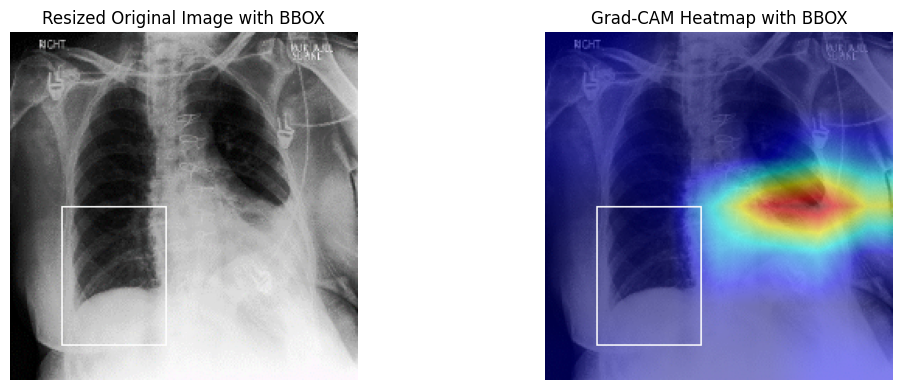

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Actual label: 1


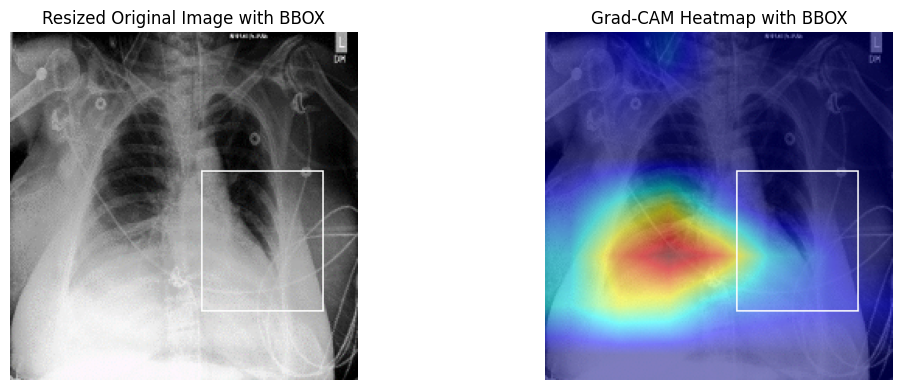

Actual label: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


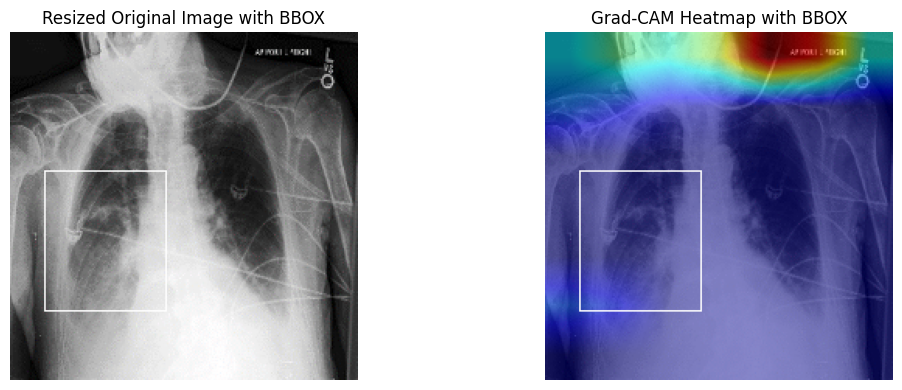

Actual label: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


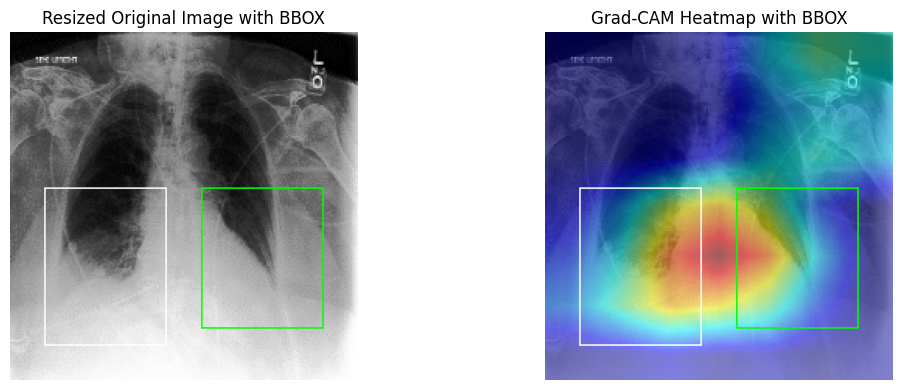

In [23]:
visualize_gradcam_with_bbox(
    model=model,
    ground_truth_images_df=ground_truth_images_df,
    ground_truth_df=ground_truth_df,
    transform=transform
)

### Visualisation of samples from the test set

In [38]:
# test_df_filtered = test_df[test_df['Pleural Effusion'] == 1]

# for i in range(15, 60, 5):
#     image_path = test_df_filtered.iloc[i]['path']
#     actual_label = test_df_filtered.iloc[i]["Pleural Effusion"]  

#     print(f"actual label {actual_label}")
#     # Only process images with effusion (label==1)
#     if actual_label == 1:
#         original_img, overlay = apply_gradcam(
#             model=model, 
#             image_path=image_path, 
#             transform=transform,
#         )
#         plt.figure(figsize=(12, 4))
#         plt.subplot(1, 3, 1)
#         plt.imshow(original_img)
#         plt.title("Resized Original Image Pleural Effusion")
#         plt.axis("off")
        
#         plt.subplot(1, 3, 2)
#         plt.imshow(overlay)
#         plt.title("Grad-CAM Heatmap Pleual Effusion")
#         plt.axis("off")
        
        
#         plt.show()

## Example-based explanation

### In this example, we do it based on ground_truth_images_df, first function is a class that extract features from specific layers
https://www.digitalocean.com/community/tutorials/pytorch-hooks-gradient-clipping-debugging#the-forward-hook-for-visualising-activations


In [24]:
import torch
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image

class FeatureExtractor:
    def __init__(self, model):
        self.model = model
        self.model.eval()  # Set model to evaluation mode
        self.activations = dict() # here we store activations per sample and then .clear() it
        
    def hook_fn(self, module, input, output):
        self.activations['output'] = output  # Store feature map
        
    def get_embeddings(self, image_paths, transform):
        embeddings = [] 
        
        # Register hook
        hook_handle = self.model.features.register_forward_hook(self.hook_fn)
        
        with torch.no_grad():  # Prevents tracking gradients
            for idx, path in enumerate(image_paths):
                # Load and preprocess image
                image = Image.open(path).convert('RGB')
                image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

                # Clear previous activations
                self.activations.clear()
                
                # Forward pass
                _ = self.model(image_tensor)
                
                # Retrieve hooked feature maps
                features = self.activations['output']
                
                # Apply ReLU activation
                features = F.relu(features, inplace=True)
                
                # Global average pooling
                pooled_features = F.adaptive_avg_pool2d(features, (1, 1))
                
                # Flatten into a 1D vector
                embedding = torch.flatten(pooled_features, 1)
                
                # Append to list after detaching from computation graph
                embeddings.append(embedding.detach().cpu())
                
                print(f"Processed image {idx+1}, embedding shape: {embedding.shape}")
        
        # Remove hook
        hook_handle.remove()
        
        return torch.cat(embeddings, dim=0)  # Combine all embeddings into one tensor




### Extracting ranked annotations

In [25]:
import os
folder = "ranking_annotations" 

ranking_image_paths = [
    os.path.join(folder, file)
    for file in os.listdir(folder) if file.startswith("Rad")] 

testing_image_path = [
    os.path.join(folder, file)
    for file in os.listdir(folder) if file.startswith("test")] 

ranking_image_paths


['ranking_annotations/Rad_8.png',
 'ranking_annotations/Rad_9.png',
 'ranking_annotations/Rad_10.png',
 'ranking_annotations/Rad_1.png',
 'ranking_annotations/Rad_2.png',
 'ranking_annotations/Rad_3.png',
 'ranking_annotations/Rad_7.png',
 'ranking_annotations/Rad_6.png',
 'ranking_annotations/Rad_4.png',
 'ranking_annotations/Rad_5.png']

### Extraction and similarity of the most similar similar images according to Test image provided

In [26]:
# Create feature extractor
extractor = FeatureExtractor(model)

# Extract embeddings
embeddings_torank = extractor.get_embeddings(image_paths=ranking_image_paths, transform=transform)
embeddings_test = extractor.get_embeddings(image_paths=testing_image_path, transform=transform)

Processed image 1, embedding shape: torch.Size([1, 1920])
Processed image 2, embedding shape: torch.Size([1, 1920])
Processed image 3, embedding shape: torch.Size([1, 1920])
Processed image 4, embedding shape: torch.Size([1, 1920])
Processed image 5, embedding shape: torch.Size([1, 1920])
Processed image 6, embedding shape: torch.Size([1, 1920])
Processed image 7, embedding shape: torch.Size([1, 1920])
Processed image 8, embedding shape: torch.Size([1, 1920])
Processed image 9, embedding shape: torch.Size([1, 1920])
Processed image 10, embedding shape: torch.Size([1, 1920])
Processed image 1, embedding shape: torch.Size([1, 1920])


In [27]:
ranking_dict = dict()
for idx, embedding_torank in enumerate(embeddings_torank):
    similarity_score = F.cosine_similarity(embedding_torank, embeddings_test)  
    print(f"Image path: {ranking_image_paths[idx]}, Similarity {float(similarity_score)}")
    ranking_dict[ranking_image_paths[idx]] = float(similarity_score)

sorted_ranking_dict = sorted(ranking_dict.items(), key=lambda x: x[1], reverse=True)

Image path: ranking_annotations/Rad_8.png, Similarity 0.46814578771591187
Image path: ranking_annotations/Rad_9.png, Similarity 0.12127915024757385
Image path: ranking_annotations/Rad_10.png, Similarity 0.2078387439250946
Image path: ranking_annotations/Rad_1.png, Similarity 0.9592630863189697
Image path: ranking_annotations/Rad_2.png, Similarity 0.93632572889328
Image path: ranking_annotations/Rad_3.png, Similarity 0.9042925834655762
Image path: ranking_annotations/Rad_7.png, Similarity 0.2120741307735443
Image path: ranking_annotations/Rad_6.png, Similarity 0.9275627136230469
Image path: ranking_annotations/Rad_4.png, Similarity 0.9458487033843994
Image path: ranking_annotations/Rad_5.png, Similarity 0.873389720916748


In [28]:
sorted_ranking_dict

[('ranking_annotations/Rad_1.png', 0.9592630863189697),
 ('ranking_annotations/Rad_4.png', 0.9458487033843994),
 ('ranking_annotations/Rad_2.png', 0.93632572889328),
 ('ranking_annotations/Rad_6.png', 0.9275627136230469),
 ('ranking_annotations/Rad_3.png', 0.9042925834655762),
 ('ranking_annotations/Rad_5.png', 0.873389720916748),
 ('ranking_annotations/Rad_8.png', 0.46814578771591187),
 ('ranking_annotations/Rad_7.png', 0.2120741307735443),
 ('ranking_annotations/Rad_10.png', 0.2078387439250946),
 ('ranking_annotations/Rad_9.png', 0.12127915024757385)]

### GradCAM on the test image

In [29]:
transform

Compose(
    Grayscale(num_output_channels=1)
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.000120070006..255.0].


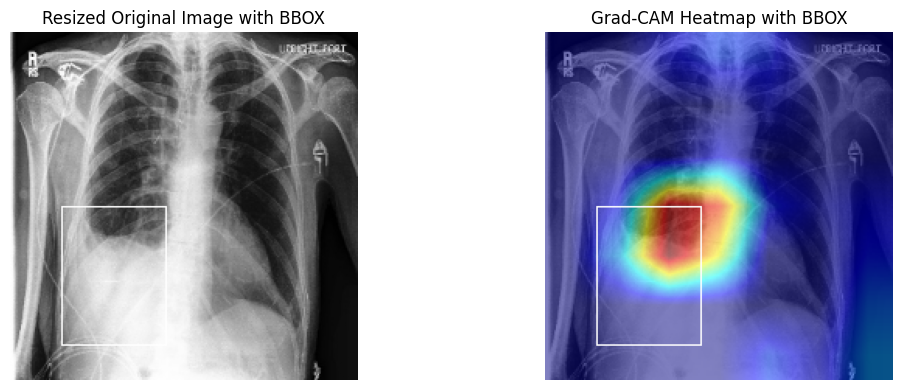

In [30]:
x_start, y_start, x_end, y_end = 48, 160, 144, 288

original_img, overlay = apply_gradcam(
            model=model,
            image_path='ranking_annotations/test_image.png',
            transform=transform)

original_width, original_height = Image.open('ranking_annotations/test_image.png').size
scale_x = 224 / original_width
scale_y = 224 / original_height

x_start_rescaled = int(x_start * scale_x)
y_start_rescaled = int(y_start * scale_y)
x_end_rescaled = int(x_end * scale_x)
y_end_rescaled = int(y_end * scale_y)


img_with_bbox = original_img.copy()

cv2.rectangle(img_with_bbox,
                (x_start_rescaled, y_start_rescaled),
                (x_end_rescaled, y_end_rescaled),
                color=(255, 255, 255),
                thickness=1)

# Draw primary BBOX on Grad-CAM Overlay
overlay_with_bbox = overlay.copy()
cv2.rectangle(overlay_with_bbox,
                (x_start_rescaled, y_start_rescaled),
                (x_end_rescaled, y_end_rescaled),
                color=(255, 255, 255),
                thickness=1)

plt.figure(figsize=(12, 4))
        
plt.subplot(1, 2, 1)
plt.imshow(img_with_bbox)
plt.title("Resized Original Image with BBOX")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay_with_bbox)
plt.title("Grad-CAM Heatmap with BBOX")
plt.axis("off")

plt.tight_layout()
plt.show()

### Gradcam on sorted by similarity samples

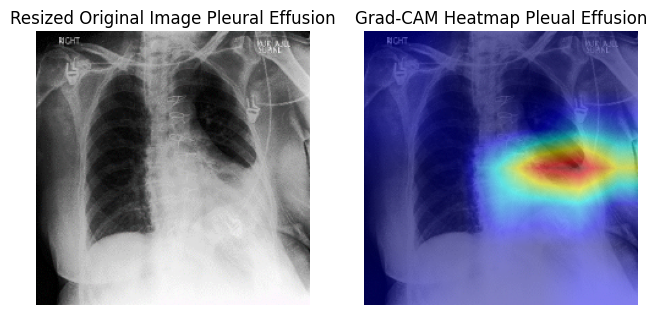

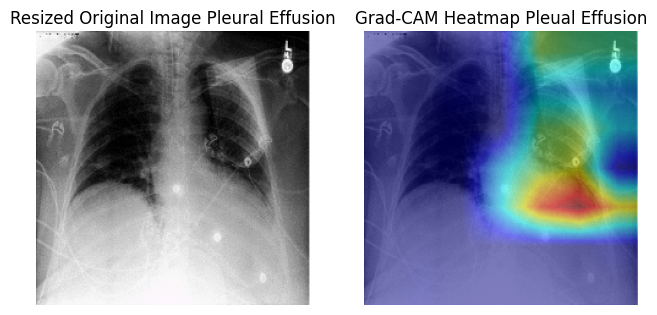

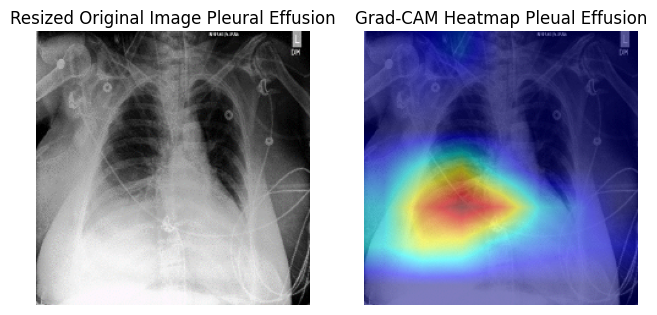

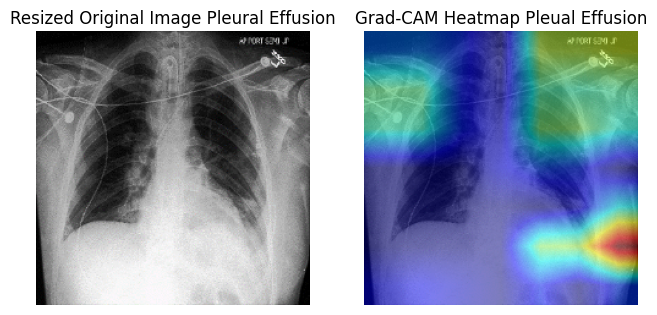

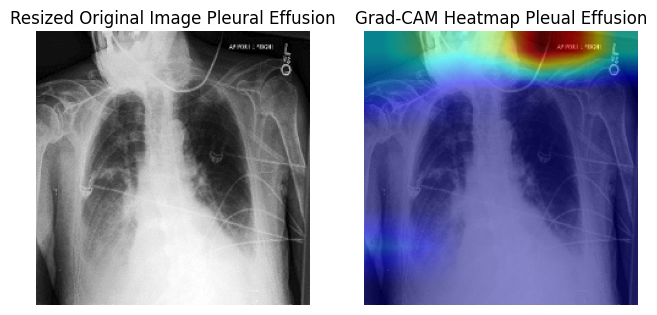

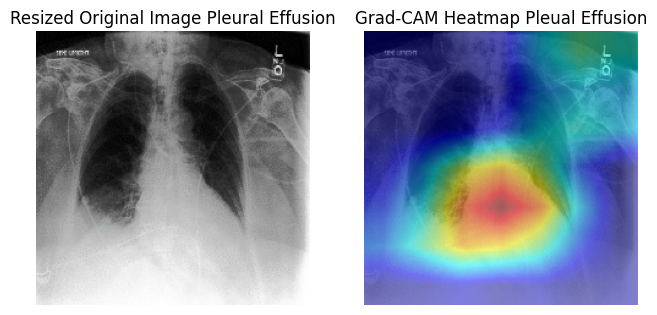

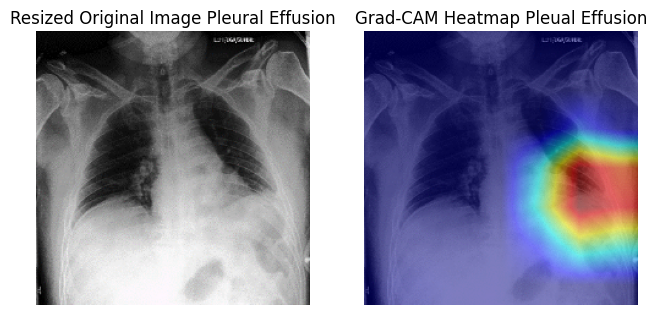

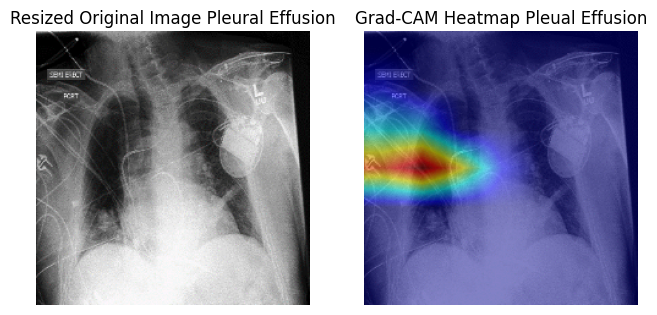

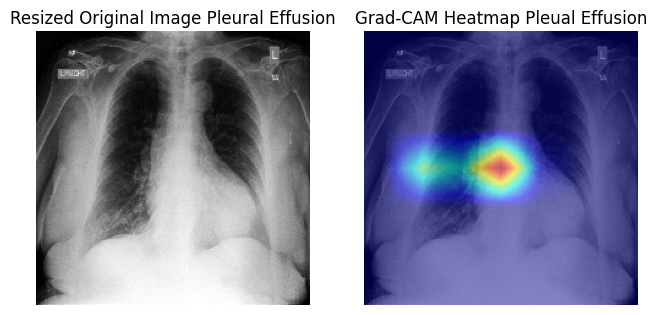

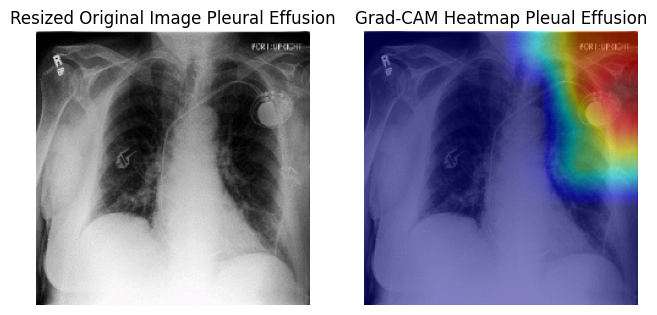

In [31]:
for i in range(len(sorted_ranking_dict)):

    image_path = sorted_ranking_dict[i][0]
    
    original_img, overlay = apply_gradcam(
            model=model, 
            image_path=image_path, 
            transform=transform)
    

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title("Resized Original Image Pleural Effusion")
    plt.axis("off")
        
    plt.subplot(1, 3, 2)
    plt.imshow(overlay)
    plt.title("Grad-CAM Heatmap Pleual Effusion")
    plt.axis("off")
    
    
    plt.show()

### Metrics

In [32]:
import numpy as np
import torch
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

def apply_gradcam_batch(model, images, target_layer=None):
    """
    Apply GradCAM to a batch of input images.

    Args:
        model: The model to generate explanations for.
        images: Batch of images as tensor [batch_size, channels, height, width].
        target_layer: Target layer for GradCAM.

    Returns:
        Dictionary with original images, GradCAM heatmaps, overlays, and predictions.
    """
    model.eval()
    device = next(model.parameters()).device

    if images.device != device:
        images = images.to(device)

    batch_size, channels, height, width = images.shape

    with torch.no_grad():
        outputs = model(images)
        predicted_classes = (torch.sigmoid(outputs) > 0.5).long().squeeze()

    if target_layer is None:
        try:
            target_layer = [model.features.denseblock4.denselayer32.conv2]
        except AttributeError:
            raise ValueError("Specify a valid target_layer for your model architecture.")

    cam = GradCAM(model=model, target_layers=target_layer)

    results = {
        "original_images": [],
        "grayscale_cams": [],
        "overlays": [],
        "predicted_classes": predicted_classes.cpu().numpy()
    }

    for i in range(batch_size):
        input_tensor = images[i:i+1]
        # print(f"input_tensor_shape {input_tensor.shape}")

        targets = [ClassifierOutputTarget(0)]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
        # print(grayscale_cam.shape)

        original_img = images[i].cpu().numpy()

        # Keep original shape (don't change channels)
        # original_img = np.squeeze(original_img)

        results["original_images"].append(original_img)
        results["grayscale_cams"].append(grayscale_cam)

        # Ensure overlay keeps the same number of channels as input
        # overlay = show_cam_on_image(original_img if channels == 3 else np.repeat(original_img[:, :, np.newaxis], 3, axis=-1), 
        #                             grayscale_cam, use_rgb=True)
        # results["overlays"].append(overlay)

    results["original_images"] = np.stack(results["original_images"], axis=0)
    results["grayscale_cams"] = np.stack(results["grayscale_cams"], axis=0)
    # results["overlays"] = np.stack(results["overlays"], axis=0)

    return results


In [33]:
test_dataset, test_loader, test_images, test_labels = transform_dataset(test_df, zip_path, batch_size=batch_size, shuffle=False, augment=False) # we extract one batch (test_images to test with)

In [34]:
ground_truth_images_df

path  label
0  ground_truth_images/Rad_1.png      1
1  ground_truth_images/Rad_2.png      1
2  ground_truth_images/Rad_3.png      1
3  ground_truth_images/Rad_5.png      1

In [235]:
import torch
import torch.nn as nn

class WrappedModel(nn.Module):
    def __init__(self, model):
        super(WrappedModel, self).__init__()
        self.model = model

    def forward(self, x):
    # Forward pass: x is expected to be a tensor
    # with torch.no_grad():
        outputs = self.model(x)  # shape: (N, 1) for binary classification
        # Apply sigmoid to get probability for the positive class
        p = torch.sigmoid(outputs)
        # Create two-class probabilities: [1 - p, p]
        probs = torch.cat([1 - p, p], dim=1)
        return probs

# Create the wrapped model
wrapped_model = WrappedModel(model)
wrapped_model.eval()


WrappedModel(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=

### THIS FUNCTION is used as an argument to the metrics in Quantus

In [236]:
def generate_saliency_map_(model, inputs, **kwargs):
    model.eval()
    
    # Ensure tensor is on the correct device and requires gradients
    device = next(model.parameters()).device  
    
    if isinstance(inputs, np.ndarray):
        inputs = torch.from_numpy(inputs).float()
    
    inputs = inputs.to(device)  # Ensure the tensor is on the correct device
    
    # Make sure input has batch dimension
    if len(inputs.shape) == 3:  # If [channels, height, width]
        inputs = inputs.unsqueeze(0)  # Add batch dimension [1, channels, height, width]
    
    # Try to get the appropriate target layer
    try:
        target_layers = [model.model.features.denseblock4.denselayer32.conv2]  # Your original layer
    except AttributeError:
        try:
            target_layers = [model.features.denseblock4.denselayer32.conv2]  # Alternative layer path
        except AttributeError:
            raise ValueError("Please specify a valid target layer for your model architecture")
    
    targets = [ClassifierOutputTarget(0)]  
    
    # Use GradCAM to calculate the saliency map
    cam = GradCAM(model=model, target_layers=target_layers)
    saliency_maps = cam(input_tensor=inputs, targets=targets)
    
    
    return saliency_maps

In [237]:
all_ground_truth_images

path  label
0  ranking_annotations/test_image.png      1
1       ground_truth_images/Rad_1.png      1
2       ground_truth_images/Rad_2.png      1
3       ground_truth_images/Rad_3.png      1
4       ground_truth_images/Rad_5.png      1

### Extracting ground truth images to calculate metrics

In [238]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd

# ground_truth_images_df = pd.DataFrame({
#         "path": [
#         "ranking_annotations/test_image.png",
#         "ground_truth_images/Rad_1.png",
#              "ground_truth_images/Rad_2.png",
#              "ground_truth_images/Rad_3.png",
#              "ground_truth_images/Rad_5.png"],
#     "label": [1, 1, 1, 1, 1]
# })


class GroundTruthDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["path"]
        label = self.df.iloc[idx]["label"]
        
        # Open Image
        image = Image.open(img_path) # Convert to grayscale
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)

# Create dataset and dataloader
ground_truth_dataset = GroundTruthDataset(all_ground_truth_images, transform=transform)
ground_truth_loader = DataLoader(ground_truth_dataset, batch_size=5, shuffle=False)

# Extract one batch
test_images, test_labels = next(iter(ground_truth_loader))



In [239]:
result_gradcam = apply_gradcam_batch(model, images=test_images)

In [240]:
x_batch, y_batch, a_batch = result_gradcam['original_images'], result_gradcam['predicted_classes'], result_gradcam['grayscale_cams']

In [241]:
import quantus

metric_robustness = quantus.LocalLipschitzEstimate(
    nr_samples=15,
    perturb_std=0.1,
    perturb_mean=0.0,
    norm_numerator=quantus.similarity_func.distance_euclidean,
    norm_denominator=quantus.similarity_func.distance_euclidean,
    perturb_func=quantus.perturb_func.gaussian_noise,
    similarity_func=quantus.similarity_func.lipschitz_constant
)

robustness = metric_robustness(
model=wrapped_model,
x_batch=x_batch,
y_batch=y_batch,
a_batch=np.array(a_batch),  # Ensure shape matches x_batch
explain_func=generate_saliency_map_
)

### works

In [203]:
import quantus

complexity = quantus.Complexity(
    return_aggregate=True
)

comp_score = complexity(
    model=wrapped_model,
    x_batch=x_batch,
    y_batch=y_batch,
    a_batch=a_batch,
    **{"device": device}
)
comp_score



[np.float64(9.893089214936001)]

### works

In [183]:
pixel_flipping = quantus.PixelFlipping(
    features_in_step=224,
    perturb_baseline="black",
    perturb_func=quantus.perturb_func.baseline_replacement_by_indices,
)

# # Call the metric instance to produce scores.
scores = pixel_flipping(model=wrapped_model,
                        x_batch=x_batch,
                        y_batch=y_batch,
                        a_batch=a_batch,
                        device=device)

### still does not work =/

In [ ]:
import quantus

metric_randomisation = quantus.MPRT()
randomisation_score = metric_randomisation(
model=wrapped_model,
x_batch=x_batch,
y_batch=y_batch,
a_batch=np.array(a_batch),  # Ensure shape matches x_batch
device=device,
explain_func=generate_saliency_map_
)

/opt/anaconda3/envs/xai/lib/python3.10/site-packages/quantus/functions/similarity_func.py:35: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return scipy.stats.spearmanr(a, b)[0]


## Localisation with segmentation mask

In [184]:
all_ground_truth_images

path  label
0  ranking_annotations/test_image.png      1
1       ground_truth_images/Rad_1.png      1
2       ground_truth_images/Rad_2.png      1
3       ground_truth_images/Rad_3.png      1
4       ground_truth_images/Rad_5.png      1

In [251]:
s_batch = []

for i in range(all_ground_truth_images.shape[0]):

    target_size=(224, 224)

    image_path = all_ground_truth_images.iloc[i]['path']
    actual_label = all_ground_truth_images.iloc[i]["label"]

    original_width, original_height = Image.open(image_path).size

    scale_x = target_size[0] / original_width
    scale_y = target_size[1] / original_height

    x_start, y_start, x_end, y_end = all_attributes_list[i].iloc[1], all_attributes_list[i].iloc[2], all_attributes_list[i].iloc[3], all_attributes_list[i].iloc[4]
    x_start_rescaled = int(x_start * scale_x)
    y_start_rescaled = int(y_start * scale_y)
    x_end_rescaled = int(x_end * scale_x)
    y_end_rescaled = int(y_end * scale_y)

    mask = np.zeros((target_size[1], target_size[0]), dtype=np.float32)  # (224, 224)

    mask[y_start_rescaled:y_end_rescaled, x_start_rescaled:x_end_rescaled] = 1.0

    s_batch.append(mask)
    
    print(f"Mask shape: {mask.shape}")
    print(f"Mask has non-zero elements: {np.any(mask > 0)}")
    print(f"Mask sum: {np.sum(mask)}")

        

Mask shape: (224, 224)
Mask has non-zero elements: True
Mask sum: 5963.0
Mask shape: (224, 224)
Mask has non-zero elements: True
Mask sum: 7020.0
Mask shape: (224, 224)
Mask has non-zero elements: True
Mask sum: 7020.0
Mask shape: (224, 224)
Mask has non-zero elements: True
Mask sum: 7878.0
Mask shape: (224, 224)
Mask has non-zero elements: True
Mask sum: 4368.0


In [252]:
s_batch = np.array(s_batch)
s_batch = np.expand_dims(s_batch, axis=1)  # New shape: (5, 1, 224, 224)


In [254]:
s_batch

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0.

In [255]:
relevance_mass_accuracy = quantus.RelevanceMassAccuracy()

localisation = relevance_mass_accuracy(
    model=model, 
    x_batch=x_batch, 
    y_batch=y_batch, 
    a_batch=a_batch, 
    s_batch=s_batch,
    explain_func=generate_saliency_map_,  
    device=device
)

In [257]:
localisation

[np.float32(0.33342057),
 np.float32(0.5251314),
 np.float32(0.49375555),
 np.float32(0.04124482),
 np.float32(0.1756022)]

## We can see that sometimes saliency maps is full 0s

In [258]:
test_tensor = test_images[3]
test_tensor = generate_saliency_map_(wrapped_model, test_tensor)
test_tensor

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.0667688 , 0.0667688 , 0.0667688 , ..., 0.18236259,
         0.18236259, 0.18236259],
        [0.0667688 , 0.0667688 , 0.0667688 , ..., 0.18236259,
         0.18236259, 0.18236259],
        [0.0667688 , 0.0667688 , 0.0667688 , ..., 0.18236259,
         0.18236259, 0.18236259]]], dtype=float32)

### Here it works

In [84]:
pixel_flipping = quantus.PixelFlipping(
    features_in_step=224,
    perturb_baseline="black",
    perturb_func=quantus.perturb_func.baseline_replacement_by_indices,
)

# # Call the metric instance to produce scores.
scores = pixel_flipping(model=wrapped_model,
                        x_batch=x_batch,
                        y_batch=y_batch,
                        a_batch=a_batch,
                        device=device)

### But if we iterate batches of images, there are many saliency maps that are 0

### Like complexity worked before because there were not 0s, now it does not work because division by abs(0) happens.
### !! i think POTENTIAL solutiom could be maybe skipping these saliency maps that are 0?


In [ ]:
for batch_idx, (x_batch, true_labels) in enumerate(tqdm(test_loader, desc="Processing batches")):
    x_batch = x_batch.to(device)  # Ensure the batch is on the correct device
    true_labels = true_labels.to(device)

    # No torch.no_grad() because we need gradients for Grad-CAM
    
    outputs = wrapped_model(x_batch)

    y_pred = outputs.argmax(dim=1).cpu().numpy()

    saliency_maps = []

    for i in range(x_batch.size(0)):
        image_tensor = x_batch[i].unsqueeze(0)
        # image_tensor.requires_grad = True
        # image_tensor.requires_grad = True  # Ensure individual image requires gradients
        
        saliency_map = generate_saliency_map_(wrapped_model, image_tensor)
        print("Saliency map stats:", 
        "Min:", np.min(saliency_map), 
        "Max:", np.max(saliency_map), 
        "Mean:", np.mean(saliency_map),
        "Sum:", np.sum(saliency_map))
        
        # break
        # break
        saliency_maps.append(saliency_map)

    # print(y_batch.shape)
    # print(saliency_maps)
    # batch_robustness = metric_robustness(
    #     model=wrapped_model,
    #     x_batch=x_batch.detach().cpu().numpy(),
    #     y_batch=y_pred,
    #     a_batch=np.array(saliency_maps),
    #     device=device,
    #     explain_func=generate_saliency_map_,
    #     batch_size=16
    # )
    # randomisation_score = metric_randomisation(
    # model=wrapped_model,
    # x_batch=x_batch.detach().cpu().numpy(),
    # y_batch=y_pred,
    # a_batch=np.array(saliency_maps),  # Ensure shape matches x_batch
    # device=device,
    # explain_func=generate_saliency_map_,
    # batch_size=16
    # )
    comp_score = complexity(
    model=wrapped_model,
    x_batch=x_batch.detach().cpu().numpy(),
    y_batch=y_pred,
    a_batch=np.array(saliency_maps))

    break


    # saliency_maps = np.array(saliency_maps)  # Convert list to array

Processing batches:   0%|          | 0/13 [00:00<?, ?it/s]

Saliency map stats: Min: 0.0 Max: 0.0 Mean: 0.0 Sum: 0.0
Saliency map stats: Min: 0.0 Max: 0.9999999 Mean: 0.02040816 Sum: 1023.9998
Saliency map stats: Min: 0.0 Max: 0.9999999 Mean: 0.09369514 Sum: 4701.2476
Saliency map stats: Min: 0.0 Max: 0.0 Mean: 0.0 Sum: 0.0
Saliency map stats: Min: 0.0 Max: 0.9999999 Mean: 0.10124477 Sum: 5080.0576
Saliency map stats: Min: 0.0 Max: 0.9999999 Mean: 0.13802953 Sum: 6925.77
Saliency map stats: Min: 0.0 Max: 0.0 Mean: 0.0 Sum: 0.0
Saliency map stats: Min: 0.0 Max: 0.0 Mean: 0.0 Sum: 0.0
Saliency map stats: Min: 0.0 Max: 0.9999999 Mean: 0.106768996 Sum: 5357.241
Saliency map stats: Min: 0.0 Max: 0.9999981 Mean: 0.020732062 Sum: 1040.252
Saliency map stats: Min: 0.0 Max: 0.0 Mean: 0.0 Sum: 0.0
Saliency map stats: Min: 0.0 Max: 0.0 Mean: 0.0 Sum: 0.0
Saliency map stats: Min: 0.0 Max: 0.9999999 Mean: 0.07454652 Sum: 3740.4465
Saliency map stats: Min: 0.0 Max: 0.9999999 Mean: 0.042967305 Sum: 2155.9275


/opt/anaconda3/envs/xai/lib/python3.10/site-packages/quantus/metrics/complexity/complexity.py:254: RuntimeWarning: invalid value encountered in divide
  a = np.array(np.reshape(a, newshape), dtype=np.float64) / np.sum(np.abs(a))
Processing batches:   0%|          | 0/13 [00:05<?, ?it/s]

Saliency map stats: Min: 0.0 Max: 0.9999999 Mean: 0.123678565 Sum: 6205.696
Saliency map stats: Min: 0.0 Max: 0.9999999 Mean: 0.21153736 Sum: 10614.099
